Descripción del proyecto.

Los clientes de Beta Bank se están yendo, cada mes, poco a poco. Los banqueros descubrieron que es más barato salvar a los clientes existentes que atraer nuevos.

Necesitamos predecir si un cliente dejará el banco pronto. Tú tienes los datos sobre el comportamiento pasado de los clientes y la terminación de contratos con el banco.

Crea un modelo con el máximo valor F1 posible. Para aprobar la revisión, necesitas un valor F1 de al menos 0.59. Verifica F1 para el conjunto de prueba. 

Además, debes medir la métrica AUC-ROC y compararla con el valor F1.

## Part 1. Preprocesamiento de Datos.

### Paso 0. Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score, recall_score, precision_score,precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

### Paso 1. Cargar y preprocesar datos.

In [2]:
df_beta_bank = pd.read_csv('Churn.csv')

In [3]:
df_beta_bank.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Los datos se cargaron correctamente.

In [4]:
df_beta_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Los datos constan de 10 000 filas y 14 columnas, de las cuales una con tiene 909 valores `NaN`. En el siguiente punto estableceremos que como vamos a sustuir sos valores.

In [5]:
df_beta_bank.describe(include='all')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000,10000.000000,10000,10000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,1.569094e+07,NaN,650.528800,NaN,NaN,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,NaN,96.653299,NaN,NaN,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,NaN,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,NaN,584.000000,NaN,NaN,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,NaN,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,NaN,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


In [6]:
#Cambiar columnas a tipo snake_case.
df_beta_bank.columns = df_beta_bank.columns.str.lower()
print(df_beta_bank.columns,'\n')
#Reeamplazar los valores nulos con el promedio de la columna Tenure.
df_beta_bank['tenure'] = df_beta_bank['tenure'].fillna(df_beta_bank['tenure'].mean())
print(df_beta_bank['tenure'],'\n')

Index(['rownumber', 'customerid', 'surname', 'creditscore', 'geography',
       'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard',
       'isactivemember', 'estimatedsalary', 'exited'],
      dtype='object') 

0        2.00000
1        1.00000
2        8.00000
3        1.00000
4        2.00000
          ...   
9995     5.00000
9996    10.00000
9997     7.00000
9998     3.00000
9999     4.99769
Name: tenure, Length: 10000, dtype: float64 



### Paso 2. Dividir el conjunto de datos.

A base en conjunto de entranamiento, prueba validación en proporción 60-20-20.

In [7]:
features = df_beta_bank.drop('exited',axis=1)
target = df_beta_bank['exited']

features_train, features_test, target_train, target_test = train_test_split(features,target,
                                                                            test_size=0.4,
                                                                            random_state=12345)
features_test, features_valid, target_test, target_valid = train_test_split(features_test,target_test,
                                                                            test_size=0.5,
                                                                            random_state=12345)

print(f"Tamaño de las características de entrenamiento:{features_train.shape}")
print(f"Tamaño de los objetivos entrenamiento: {target_train.shape}\n")
print(f"Tamaño de las características de prueba:{features_test.shape}")
print(f"Tamaño de los objetivos prueba: {target_test.shape}\n")
print(f"Tamaño de las características de validación:{features_valid.shape}")
print(f"Tamaño de los objetivos de validación: {target_valid.shape}")

Tamaño de las características de entrenamiento:(6000, 13)
Tamaño de los objetivos entrenamiento: (6000,)

Tamaño de las características de prueba:(2000, 13)
Tamaño de los objetivos prueba: (2000,)

Tamaño de las características de validación:(2000, 13)
Tamaño de los objetivos de validación: (2000,)


### Paso 3. Desequilibrio de clases.

In [8]:
print(target_train.value_counts())
print(target_test.value_counts())
print(target_valid.value_counts())


exited
0    4804
1    1196
Name: count, dtype: int64
exited
0    1582
1     418
Name: count, dtype: int64
exited
0    1577
1     423
Name: count, dtype: int64


        count  count
exited              
0        4804   1582
1        1196    418
        count  count  count
exited                     
0        4804   1582   1577
1        1196    418    423


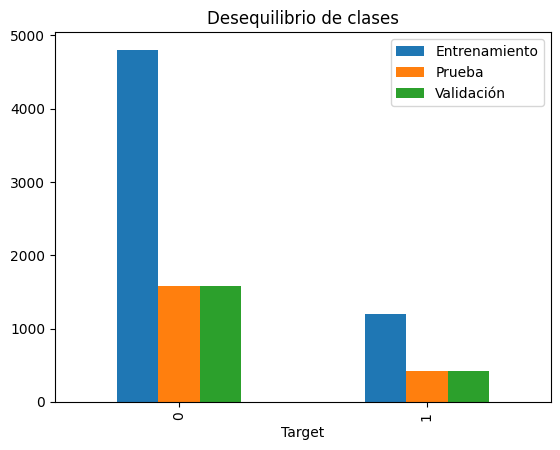

In [9]:
concat_part1 = pd.concat([target_train.value_counts(),target_test.value_counts()],axis=1)
print(concat_part1)

concat_part2 = pd.concat([concat_part1,target_valid.value_counts()],axis=1)
print(concat_part2)

concat_part2.columns = ['Entrenamiento','Prueba','Validación']
concat_part2.plot(kind='bar',title='Desequilibrio de clases',xlabel='Target')
plt.show()

En el conjunto de datos hay más `0's` que `1's`. Vamos a entrenar los modelos sin tomar y tomando en cuenta el desequilibrio de las clases.

## Parte 2. Aplicación, evaluación y mejora de modelos.

### Paso 4. Codificación y escalamiento.

In [10]:
# def ohe_scale(features):
#     ohe_features = pd.get_dummies(features,drop_first=True)
#     scaler = StandardScaler()
#     scaled_features = pd.DataFrame(scaler.fit_transform(ohe_features))
#     return scaled_features

In [11]:
def OEncoder_scale(features):
    encoder = OrdinalEncoder() #Codificación
    encoded_features = encoder.fit_transform(features) 
    scaler = StandardScaler() #Escalamiento
    scaled_features = pd.DataFrame(scaler.fit_transform(encoded_features),columns=features.columns)
    return scaled_features

In [12]:
scaled_features_train = OEncoder_scale(features_train)
scaled_features_test = OEncoder_scale(features_test)
scaled_features_valid = OEncoder_scale(features_valid)

### Paso 5. Regresión Logística

##### Modelo.

In [13]:
#Si tomar en cuenta el desequilibrrio.
model = LogisticRegression(solver='liblinear')
model.fit(scaled_features_train,target_train)

train_prediction = model.predict(scaled_features_train)
test_prediction = model.predict(scaled_features_test)
valid_prediction = model.predict(scaled_features_valid)

print('Exactitud con el método accuracy_score\n')
print(f"Entrenameinto: {accuracy_score(target_train,train_prediction)}")
print(f"Prueba: {accuracy_score(target_test,test_prediction)}")
print(f"Validación: {accuracy_score(target_valid,valid_prediction)}")

Exactitud con el método accuracy_score

Entrenameinto: 0.8155
Prueba: 0.8005
Validación: 0.797


#### Paso 5.1 Prueba de cordura.

##### Predición lineal con 0.

In [14]:
prediction = pd.Series(0, index=target_valid.index)
print('Prueba de cordura si el modelo lineal predice que que ningún cliente se ha ido.\n')
print(f"Exactitud de validación: {accuracy_score(target_valid,prediction)}")
print(f"Esaxtitud de prueba: {accuracy_score(target_test,prediction)}")

Prueba de cordura si el modelo lineal predice que que ningún cliente se ha ido.

Exactitud de validación: 0.7885
Esaxtitud de prueba: 0.791


##### Predición lineal con 1.

In [15]:
prediction = pd.Series(1, index=target_valid.index)
print('Prueba de cordura si el modelo predice que que ningún cliente se ha ido.\n')
print(f"Exactitud de validación: {accuracy_score(target_valid,prediction)}")
print(f"Exactitud de prueba: {accuracy_score(target_test,prediction)}")

Prueba de cordura si el modelo predice que que ningún cliente se ha ido.

Exactitud de validación: 0.2115
Exactitud de prueba: 0.209


#### Paso 5.2 Matriz de confusión.

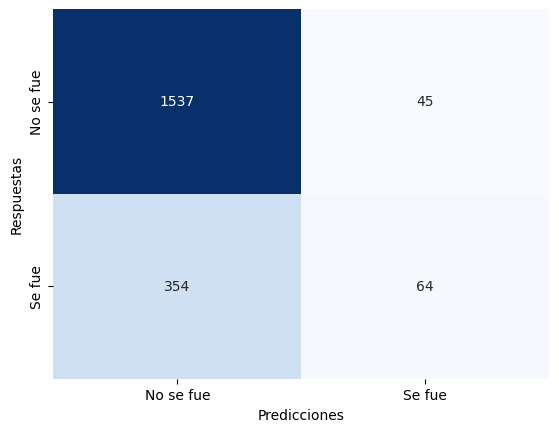

In [16]:
matrix = sns.heatmap(confusion_matrix(target_test,test_prediction),
                     annot=True,fmt='.5g',
                     cbar=False,cmap='Blues',
                     xticklabels=['No se fue','Se fue'],
                     yticklabels=['No se fue','Se fue'])
matrix.set_xlabel('Predicciones')
matrix.set_ylabel('Respuestas')
plt.show()

Las matriz de confusión en el conjunto de pruebas nos indica que:
- El modelo predijo que 1537 clientes seguirán depositando su dinero en el banco cuando realmente el cliente continuará usando su cuenta de banco. Estos son `verdaros negativos`.
- El modelo predijo que 64 cliente tomó la decisión de guardar su dinero a otro banco cuando realmente si dejó de ser cliente. Estos son los `verdaderos positivos`.
- El modelo predijo que 45 clientes tomaron la decisón de guardar el dinero en otro banco cuando nunca dejó de ser cliente. Estos son los `falsos positivos`.
- El model predijo que 364 cliente siguen depositando su dinero en el banco cuando no ya dejaron de ser clientes. Estos son los `falsos negativos`.

#### Paso 5.3 Métricas de recall, precision y f1.

In [17]:
print(f"Recall: {recall_score(target_test,test_prediction)}")

print(f"Precision: {precision_score(target_test,test_prediction)}")

print(f"Valor F1: {f1_score(target_test,test_prediction)}")

Recall: 0.15311004784688995
Precision: 0.5871559633027523
Valor F1: 0.2428842504743833


Nuestro valor F1 está alejado de ser estar en la relación de recall a precision 1:1

##### Ajustes de pesos en el modelo.

In [18]:
model = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced')
model.fit(scaled_features_train,target_train)

train_prediction = model.predict(scaled_features_train)
test_prediction = model.predict(scaled_features_test)
valid_prediction = model.predict(scaled_features_valid)

print(f"Valor F1 entrenamiento: {f1_score(target_test,test_prediction)}")
print(f"Valor F1 validación : {f1_score(target_valid,valid_prediction)}")

Valor F1 entrenamiento: 0.47528187337380745
Valor F1 validación : 0.4743150684931507


Nuestro modelo mejoró bastante gracias al ajustar el peso de clases. Ahora aplicaremos sobre y submuestreo para ver si mejora un poco más el valor F1.

#### Paso 5.4 Valor F1 con sobremuestreo y submuestreo.

##### 5.4.1 Sobremuestreo

In [19]:
def upsample(features,target,repeat): #Función para calcular sobremuestro del conjunto de datos.
    target = target.reset_index(drop=True)
    features_zeros = features[target == 0]
    target_zeros = target[target == 0]
    features_ones = features[target == 1]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones]*repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones]*repeat)
    
    features_upsampled, target_umsamples = shuffle(features_upsampled,target_upsampled,random_state=12345)
    
    return features_upsampled, target_umsamples

In [20]:
features_upsampled, target_upsampled = upsample(scaled_features_train,target_train,10)

print(features_upsampled.shape)
print(target_upsampled.shape)

model = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced')
model.fit(features_upsampled,target_upsampled)

valid_prediction = model.predict(scaled_features_valid)
test_prediction = model.predict(scaled_features_test)

print(f"\nValor F1 validación: {f1_score(target_valid,valid_prediction)}\n")
print(f"Valor F1 entrenamiento: {f1_score(target_test,test_prediction)}")

(16764, 13)
(16764,)

Valor F1 validación: 0.4743150684931507

Valor F1 entrenamiento: 0.47528187337380745


##### 5.4.2 Submuestreo

In [21]:
def downsample(features,target,fraction):
    target = target.reset_index(drop=True)
    features_zeros = features[target == 0]
    target_zeros = target[target == 0]
    features_ones = features[target == 1]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction,random_state=12345)]+[features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction,random_state=12345)]+[target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled,target_downsampled,random_state=12345)
    
    return features_downsampled, target_downsampled

In [22]:
features_downsampled, target_downsampled = downsample(scaled_features_train,target_train,0.1)

print(features_downsampled.shape)
print(target_downsampled.shape)

model = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced')
model.fit(features_downsampled,target_downsampled)

valid_prediction = model.predict(scaled_features_valid)
test_prediction = model.predict(scaled_features_test)

print(f"\nValor F1 validación con submuestreo: {f1_score(target_valid,valid_prediction)}\n")
print(f"Valor F1 entrenamiento con submuestreo: {f1_score(target_test,test_prediction)}")

(1676, 13)
(1676,)

Valor F1 validación con submuestreo: 0.46621621621621623

Valor F1 entrenamiento con submuestreo: 0.47700170357751276


#### Paso 5.5 Umbral de clasificación y ajuste.

In [23]:
# model = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced')
# model.fit(scaled_features_train,target_train)

# def custom_predict(features,threshold):
#     probabilities_one_valid = model.predict_proba(features)
#     prediction = probabilities_one_valid[:,1] > threshold
#     return prediction

# print(custom_predict(scaled_features_train,0.3))

In [24]:
model = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced') #Modelo balanceado
model.fit(scaled_features_train,target_train) #Entrenameinto

probabilities_test = model.predict_proba(scaled_features_test) #Entrenamiento
probabilities_one_test = probabilities_test[:,1]

probabilities_valid = model.predict_proba(scaled_features_valid) #Validación
probabilities_one_valid = probabilities_valid[:,1]

best_valid_f1 = 0
best_test_f1 = 0
best_valid_threshold = 0
best_test_threshold = 0

print('Conjunto de entrenamiento:\n')
for threshold in np.arange(0,1,0.05):
    predicted_test = probabilities_one_test > threshold
    precision = precision_score(target_test,predicted_test)
    recall = recall_score(target_test,predicted_test)
    f1 = f1_score(target_test,predicted_test)
    print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, F1 = {:.3F}'.format(threshold, precision, recall,f1))
    if f1 > best_test_f1:
        best_test_f1 = f1
        best_test_threshold = threshold
    
print('\nConjunto de validación:\n')
for threshold in np.arange(0,1,0.05):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid,predicted_valid)
    recall = recall_score(target_valid,predicted_valid)
    f1 = f1_score(target_valid,predicted_valid)
    print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, F1 = {:.3F}'.format(threshold, precision, recall,f1))
    if f1 > best_valid_f1:
        best_valid_f1 = f1
        best_valid_threshold = threshold

Conjunto de entrenamiento:

Threshold = 0.00 | Precision = 0.209, Recall = 1.000, F1 = 0.346
Threshold = 0.05 | Precision = 0.209, Recall = 1.000, F1 = 0.346
Threshold = 0.10 | Precision = 0.214, Recall = 1.000, F1 = 0.352
Threshold = 0.15 | Precision = 0.225, Recall = 0.993, F1 = 0.367
Threshold = 0.20 | Precision = 0.239, Recall = 0.976, F1 = 0.385
Threshold = 0.25 | Precision = 0.255, Recall = 0.938, F1 = 0.401
Threshold = 0.30 | Precision = 0.273, Recall = 0.900, F1 = 0.418
Threshold = 0.35 | Precision = 0.295, Recall = 0.847, F1 = 0.437
Threshold = 0.40 | Precision = 0.321, Recall = 0.799, F1 = 0.458
Threshold = 0.45 | Precision = 0.348, Recall = 0.742, F1 = 0.474
Threshold = 0.50 | Precision = 0.373, Recall = 0.656, F1 = 0.475
Threshold = 0.55 | Precision = 0.409, Recall = 0.600, F1 = 0.486
Threshold = 0.60 | Precision = 0.437, Recall = 0.517, F1 = 0.474
Threshold = 0.65 | Precision = 0.469, Recall = 0.445, F1 = 0.456
Threshold = 0.70 | Precision = 0.495, Recall = 0.333, F1 = 0.3

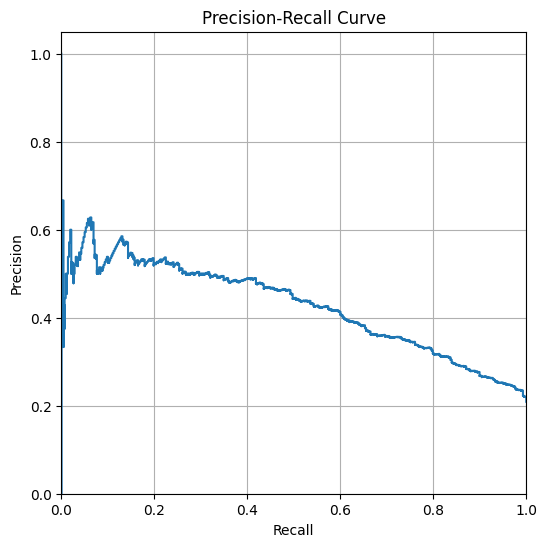

In [25]:
model = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced')
model.fit(scaled_features_train,target_train)

probabilities_test = model.predict_proba(scaled_features_test)
precision, recall, thresholds = precision_recall_curve(
    target_test, probabilities_test[:, 1]
)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [26]:
print(f"Umbral {best_test_threshold} con mejor valor f1 en el conjunto de entrenamiento: {best_test_f1}\n")
print(f"Umbral {best_valid_threshold} con mejor valor f1 en el conjunto de validación: {best_valid_f1}\n")
print(f"AUC-ROC: {roc_auc_score(target_test,probabilities_test[:,1])}")

Umbral 0.55 con mejor valor f1 en el conjunto de entrenamiento: 0.48643410852713176

Umbral 0.5 con mejor valor f1 en el conjunto de validación: 0.4743150684931507

AUC-ROC: 0.7512460757686654


Para que identificar la mayoría de clientes que se han ido, mantener el Recall con una métrica alta e identificar la mayor cantidad posible de valores positivos, el mejor ajuste de umbral es `0.5`. Sin embargo, el valor de f1 aún es muy bajo con `0.475` y no alcanzamos valor objetivo de `0.59`. Aplicaremos otro modelo.

Nuestro modelo no es el mejor para identificar y predecir los clientes que se irán.

### Paso 6. Bosques Aleatorios.

##### Modelo.

In [27]:
#Sin tomar en cuenta el desiquilibrio de los datos.
model = RandomForestClassifier(n_estimators=10,random_state=12345)
model.fit(scaled_features_train,target_train)

train_prediction = model.predict(scaled_features_train)
test_prediction = model.predict(scaled_features_test)
valid_prediction = model.predict(scaled_features_valid)

print('Exactitud con el método accuracy_score\n')
print(f"Entrenameinto: {accuracy_score(target_train,train_prediction)}")
print(f"Prueba: {accuracy_score(target_test,test_prediction)}")
print(f"Validación: {accuracy_score(target_valid,valid_prediction)}")

Exactitud con el método accuracy_score

Entrenameinto: 0.9878333333333333
Prueba: 0.8495
Validación: 0.831


#### Paso 6.1 Matriz de confusión.

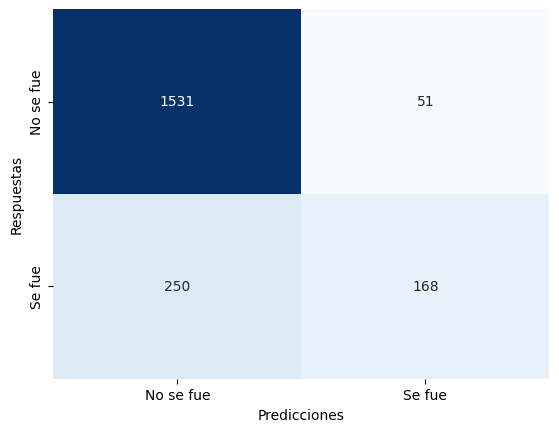

In [28]:
matrix = sns.heatmap(confusion_matrix(target_test,test_prediction),
                     annot=True,fmt='.5g',
                     cbar=False,cmap='Blues',
                     xticklabels=['No se fue','Se fue'],
                     yticklabels=['No se fue','Se fue'])
matrix.set_xlabel('Predicciones')
matrix.set_ylabel('Respuestas')
plt.show()

Resultados muy parecidor a la Regresión Logistica.

#### Paso 6.2 Métricas de recall, precision y f1.

In [29]:
print(f"Recall: {recall_score(target_test,test_prediction)}\n")

print(f"Precision: {precision_score(target_test,test_prediction)}\n")

print(f"Valor F1: {f1_score(target_test,test_prediction)}")

Recall: 0.4019138755980861

Precision: 0.7671232876712328

Valor F1: 0.5274725274725275


Resultados de recall, precisión y valor f1 del modelo con hiperparámetro `n_estimator=10`. Exploraremos con más detalle cuál es el mejor valor de este hiperparametro para tener el valor f1 más alto.

##### Paso 6.3 Identificar el mejor valor f1 con cambios en el hiperparametro `n_estimators`.

In [30]:
valor_f1 = 0
list = []
for estimator in np.arange(1,50,1):
    model = RandomForestClassifier(n_estimators=estimator,random_state=12345)
    model.fit(scaled_features_train,target_train)
    prediction = model.predict(scaled_features_valid)
    valor_f1 = f1_score(target_valid,prediction)
    list.append(valor_f1)
    print(f"Valor F1: {valor_f1}")

Valor F1: 0.42790697674418604
Valor F1: 0.33158813263525305
Valor F1: 0.4631578947368421
Valor F1: 0.4288
Valor F1: 0.4803370786516854
Valor F1: 0.45614035087719296
Valor F1: 0.5142857142857142
Valor F1: 0.48177496038034867
Valor F1: 0.5044510385756676
Valor F1: 0.4651898734177215
Valor F1: 0.5075075075075075
Valor F1: 0.48598130841121495
Valor F1: 0.4864864864864865
Valor F1: 0.4836193447737909
Valor F1: 0.49016641452344933
Valor F1: 0.48382126348228044
Valor F1: 0.5015105740181269
Valor F1: 0.48286604361370716
Valor F1: 0.48854961832061067
Valor F1: 0.48049921996879874
Valor F1: 0.49244712990936557
Valor F1: 0.475
Valor F1: 0.487062404870624
Valor F1: 0.49139280125195617
Valor F1: 0.4976958525345622
Valor F1: 0.4890282131661442
Valor F1: 0.5
Valor F1: 0.48417721518987344
Valor F1: 0.5100463678516228
Valor F1: 0.4936708860759494
Valor F1: 0.5007776049766719
Valor F1: 0.49607535321821034
Valor F1: 0.4984520123839009
Valor F1: 0.48503937007874015
Valor F1: 0.49375
Valor F1: 0.4849445324

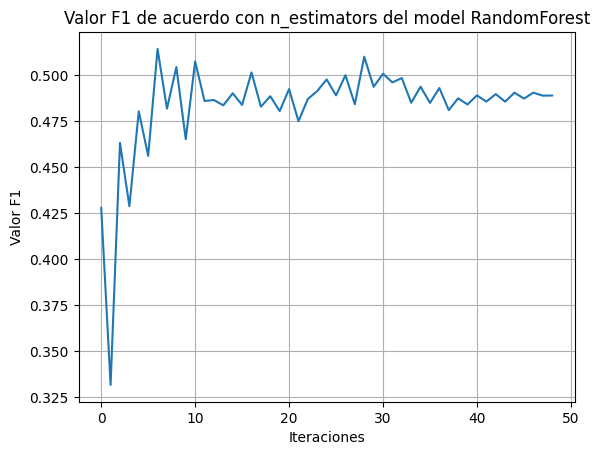

In [31]:
plt.plot(list)
plt.xlabel('Iteraciones')
plt.ylabel('Valor F1')
plt.title('Valor F1 de acuerdo con n_estimators del model RandomForest')
plt.grid(True)
plt.show()

En la gráfica podemos obsvervar en las primeras iteraciones va ascendiendo el valor de f1 hasta llegar a casi una línea plana.

#### Paso 6.3 Valor F1 con sobremuestreo y submuestreo.

##### 6.3.1 Sobremuestreo

In [32]:
upsampled_features,upsampled_target = upsample(scaled_features_train,target_train,10)

In [33]:
valor_f1 = 0
list = []
for estimator in np.arange(1,50,1):
    model = RandomForestClassifier(n_estimators=estimator,random_state=12345)
    upsampled_features,upsampled_target = upsample(scaled_features_train,target_train,10)
    model.fit(upsampled_features,upsampled_target)
    prediction = model.predict(scaled_features_valid)
    valor_f1 = f1_score(target_valid,prediction)
    list.append(valor_f1)
    print(f"Valor F1: {valor_f1}")

Valor F1: 0.4035476718403548
Valor F1: 0.34169278996865204
Valor F1: 0.4380264741275572
Valor F1: 0.41896024464831805
Valor F1: 0.49548387096774194
Valor F1: 0.4497751124437781
Valor F1: 0.507343124165554
Valor F1: 0.48034934497816595
Valor F1: 0.5126835781041389
Valor F1: 0.48703170028818443
Valor F1: 0.5248990578734859
Valor F1: 0.5007278020378457
Valor F1: 0.5218579234972678
Valor F1: 0.4985507246376812
Valor F1: 0.5220994475138122
Valor F1: 0.4956268221574344
Valor F1: 0.5220994475138122
Valor F1: 0.502906976744186
Valor F1: 0.5232067510548524
Valor F1: 0.5073313782991202
Valor F1: 0.5154929577464789
Valor F1: 0.49854227405247814
Valor F1: 0.5258741258741259
Valor F1: 0.5094066570188133
Valor F1: 0.5277777777777778
Valor F1: 0.5157593123209169
Valor F1: 0.5236768802228412
Valor F1: 0.5179856115107914
Valor F1: 0.5260196905766527
Valor F1: 0.5164051355206848
Valor F1: 0.5292479108635098
Valor F1: 0.5254237288135594
Valor F1: 0.5299860529986054
Valor F1: 0.5255681818181818
Valor F1: 

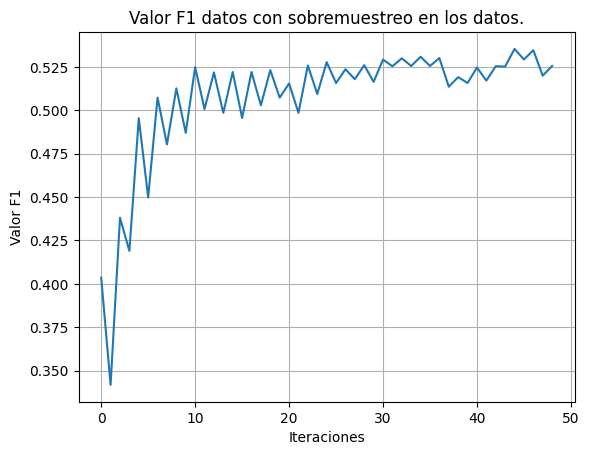

In [34]:
plt.plot(list)
plt.xlabel('Iteraciones')
plt.ylabel('Valor F1')
plt.title('Valor F1 datos con sobremuestreo en los datos.')
plt.grid(True)
plt.show()

Con la yuda de la técnica de sobremuestreo subió un poco más el valor de f1 pero no al valor que estamos buscando.

##### 6.3.2 Submuestreo

In [35]:
valor_f1 = 0
list = []
for estimator in np.arange(1,50,1):
    model = RandomForestClassifier(n_estimators=estimator,random_state=12345)
    downsampled_features,downsampled_target = downsample(scaled_features_train,target_train,0.1)
    model.fit(downsampled_features,downsampled_target)
    prediction = model.predict(scaled_features_valid)
    valor_f1 = f1_score(target_valid,prediction)
    list.append(valor_f1)
    print(f"Valor F1: {valor_f1}")

Valor F1: 0.37522334723049433
Valor F1: 0.42235004108463436
Valor F1: 0.4082352941176471
Valor F1: 0.43794579172610554
Valor F1: 0.42578356002365464
Valor F1: 0.4477211796246649
Valor F1: 0.429664508534432
Valor F1: 0.44879321591650356
Valor F1: 0.42907801418439717
Valor F1: 0.44222361024359774
Valor F1: 0.4243818286371478
Valor F1: 0.4438964241676942
Valor F1: 0.4276583381754794
Valor F1: 0.4527829893683552
Valor F1: 0.43366452367036823
Valor F1: 0.45318352059925093
Valor F1: 0.4432686654908877
Valor F1: 0.45213094502779494
Valor F1: 0.4412811387900356
Valor F1: 0.4504950495049505
Valor F1: 0.4399524375743163
Valor F1: 0.45073891625615764
Valor F1: 0.4416961130742049
Valor F1: 0.4489051094890511
Valor F1: 0.4477259303012404
Valor F1: 0.4528763769889841
Valor F1: 0.45211183819155265
Valor F1: 0.45616186388718577
Valor F1: 0.44991212653778556
Valor F1: 0.4538834951456311
Valor F1: 0.44574780058651026
Valor F1: 0.4566929133858268
Valor F1: 0.4467960023515579
Valor F1: 0.45383222691611347

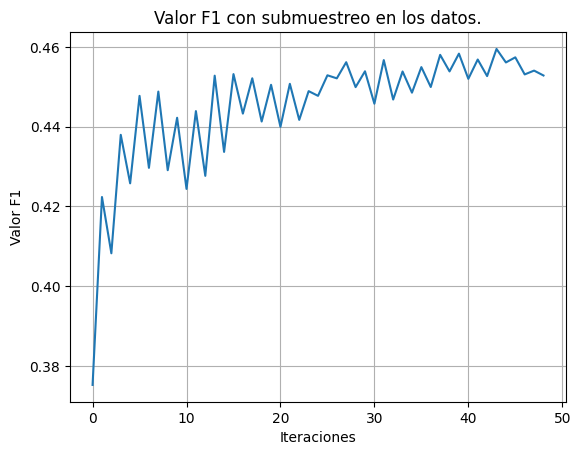

In [36]:
plt.plot(list)
plt.xlabel('Iteraciones')
plt.ylabel('Valor F1')
plt.title('Valor F1 con submuestreo en los datos.')
plt.grid(True)
plt.show()

En el submuestreo decendió el valor de f1.

#### Paso 6.4 Umbral de clasificación y ajuste.


En esta sección seguiremos haciendo pruebas juntando los dos pasos 6.3 e identificar el umbral más alto en cada iteración del modelo. Aplicaremos dos cilcos `for` en el cuales va a ir cambiando el hiperparametro `n_estimatores` y el `umbral` de clasificación respectivamente para visualizar diferentes resultados de `precision`, `recall` y `f1_score` y seleccionar la iteración con el mejor valor de `f1`. Lo aplicaremos tanto el en conjunto con sobremuestreo y submuestreo. Se trabajaran en este caso con el conjunto de validación.

In [37]:
#valor_f1 = 0
best_f1 = 0
best_estimator = 0

for estimator in np.arange(1,50,1):
    model = RandomForestClassifier(n_estimators=estimator,random_state=12345)
    model.fit(scaled_features_train,target_train)
    
    probabilities_test = model.predict_proba(scaled_features_test)
    probabilities_one_test = probabilities_test[:,1]
    
    print(f"Iteracion: {estimator}")
    
    for threshold in np.arange(0,1,0.05):
        
        predicted_test = probabilities_one_test > threshold
        
        precision = precision_score(target_test,predicted_test)
        recall = recall_score(target_test,predicted_test)
        f1 = f1_score(target_test,predicted_test)
        
        print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, F1 = {:.3F}'.format(threshold, precision, recall,f1))  
        
        if f1 > best_f1:
            best_f1 = f1
            best_estimator = estimator
    # model.fit(upsampled_features,upsampled_target)
    # prediction = model.predict(scaled_features_valid)
    # valor_f1 = f1_score(target_valid,prediction)
    # list.append(valor_f1)
    # print(f"Valor F1: {valor_f1}")
    
print(f"\nEl mejor valor de f1 es {best_f1} en la iteración {best_estimator} sin manipular el conjunto de datos.")

Iteracion: 1
Threshold = 0.00 | Precision = 0.409, Recall = 0.445, F1 = 0.426
Threshold = 0.05 | Precision = 0.409, Recall = 0.445, F1 = 0.426
Threshold = 0.10 | Precision = 0.409, Recall = 0.445, F1 = 0.426
Threshold = 0.15 | Precision = 0.409, Recall = 0.445, F1 = 0.426
Threshold = 0.20 | Precision = 0.409, Recall = 0.445, F1 = 0.426
Threshold = 0.25 | Precision = 0.409, Recall = 0.445, F1 = 0.426
Threshold = 0.30 | Precision = 0.409, Recall = 0.445, F1 = 0.426
Threshold = 0.35 | Precision = 0.409, Recall = 0.445, F1 = 0.426
Threshold = 0.40 | Precision = 0.409, Recall = 0.445, F1 = 0.426
Threshold = 0.45 | Precision = 0.409, Recall = 0.445, F1 = 0.426
Threshold = 0.50 | Precision = 0.409, Recall = 0.445, F1 = 0.426
Threshold = 0.55 | Precision = 0.409, Recall = 0.445, F1 = 0.426
Threshold = 0.60 | Precision = 0.409, Recall = 0.445, F1 = 0.426
Threshold = 0.65 | Precision = 0.409, Recall = 0.445, F1 = 0.426
Threshold = 0.70 | Precision = 0.409, Recall = 0.445, F1 = 0.426
Threshold = 

##### Paso 6.2.1 Sobremuestreo.

In [38]:
#valor_f1 = 0
best_f1 = 0
best_estimator = 0

for estimator in np.arange(1,50,1):
    model = RandomForestClassifier(n_estimators=estimator,random_state=12345)
    upsampled_features,upsampled_target = upsample(scaled_features_train,target_train,10)
    model.fit(upsampled_features,upsampled_target)
    
    probabilities_valid = model.predict_proba(scaled_features_valid)
    probabilities_one_valid = probabilities_valid[:,1]
    
    print(f"Iteracion: {estimator}")
    
    for threshold in np.arange(0,1,0.05):
        
        predicted_valid = probabilities_one_valid > threshold
        
        precision = precision_score(target_valid,predicted_valid)
        recall = recall_score(target_valid,predicted_valid)
        f1 = f1_score(target_valid,predicted_valid)
        
        print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, F1 = {:.3F}'.format(threshold, precision, recall,f1))  
        
        if f1 > best_f1:
            best_f1 = f1
            best_estimator = estimator
    # model.fit(upsampled_features,upsampled_target)
    # prediction = model.predict(scaled_features_valid)
    # valor_f1 = f1_score(target_valid,prediction)
    # list.append(valor_f1)
    # print(f"Valor F1: {valor_f1}")
    
print(f"\nEl mejor valor de f1 es {best_f1} en la iteración {best_estimator} con cobremuestreo.")

Iteracion: 1
Threshold = 0.00 | Precision = 0.380, Recall = 0.430, F1 = 0.404
Threshold = 0.05 | Precision = 0.380, Recall = 0.430, F1 = 0.404
Threshold = 0.10 | Precision = 0.380, Recall = 0.430, F1 = 0.404
Threshold = 0.15 | Precision = 0.380, Recall = 0.430, F1 = 0.404
Threshold = 0.20 | Precision = 0.380, Recall = 0.430, F1 = 0.404
Threshold = 0.25 | Precision = 0.380, Recall = 0.430, F1 = 0.404
Threshold = 0.30 | Precision = 0.380, Recall = 0.430, F1 = 0.404
Threshold = 0.35 | Precision = 0.380, Recall = 0.430, F1 = 0.404
Threshold = 0.40 | Precision = 0.380, Recall = 0.430, F1 = 0.404
Threshold = 0.45 | Precision = 0.380, Recall = 0.430, F1 = 0.404
Threshold = 0.50 | Precision = 0.380, Recall = 0.430, F1 = 0.404
Threshold = 0.55 | Precision = 0.380, Recall = 0.430, F1 = 0.404
Threshold = 0.60 | Precision = 0.380, Recall = 0.430, F1 = 0.404
Threshold = 0.65 | Precision = 0.380, Recall = 0.430, F1 = 0.404
Threshold = 0.70 | Precision = 0.380, Recall = 0.430, F1 = 0.404
Threshold = 

##### Paso 6.4.2 Submuestreo.

In [39]:

valor_f1 = 0
best_f1 = 0
best_estimator = 0
list = []
for estimator in np.arange(1,50,1):
    model = RandomForestClassifier(n_estimators=estimator,random_state=12345)
    downsampled_features,downsampled_target = downsample(scaled_features_train,target_train,0.1)
    model.fit(downsampled_features,downsampled_target)    
    probabilities_valid = model.predict_proba(scaled_features_valid)
    probabilities_one_valid = probabilities_valid[:,1]
    print(f"Iteracion: {estimator}")
    for threshold in np.arange(0,1,0.05):
        predicted_valid = probabilities_one_valid > threshold
        precision = precision_score(target_valid,predicted_valid)
        recall = recall_score(target_valid,predicted_valid)
        f1 = f1_score(target_valid,predicted_valid)
        print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, F1 = {:.3F}'.format(threshold, precision, recall,f1))  
        if f1 > best_f1:
            best_f1 = f1
            best_estimator = estimator
    # model.fit(upsampled_features,upsampled_target)
    # prediction = model.predict(scaled_features_valid)
    # valor_f1 = f1_score(target_valid,prediction)
    # list.append(valor_f1)
    # print(f"Valor F1: {valor_f1}")
print(f"\nEl mejor valor de f1 es {best_f1} en la iteración {best_estimator} con submuestreo.")

Iteracion: 1
Threshold = 0.00 | Precision = 0.251, Recall = 0.745, F1 = 0.375
Threshold = 0.05 | Precision = 0.251, Recall = 0.745, F1 = 0.375
Threshold = 0.10 | Precision = 0.251, Recall = 0.745, F1 = 0.375
Threshold = 0.15 | Precision = 0.251, Recall = 0.745, F1 = 0.375
Threshold = 0.20 | Precision = 0.251, Recall = 0.745, F1 = 0.375
Threshold = 0.25 | Precision = 0.251, Recall = 0.745, F1 = 0.375
Threshold = 0.30 | Precision = 0.251, Recall = 0.745, F1 = 0.375
Threshold = 0.35 | Precision = 0.251, Recall = 0.745, F1 = 0.375
Threshold = 0.40 | Precision = 0.251, Recall = 0.745, F1 = 0.375
Threshold = 0.45 | Precision = 0.251, Recall = 0.745, F1 = 0.375
Threshold = 0.50 | Precision = 0.251, Recall = 0.745, F1 = 0.375
Threshold = 0.55 | Precision = 0.251, Recall = 0.745, F1 = 0.375
Threshold = 0.60 | Precision = 0.251, Recall = 0.745, F1 = 0.375
Threshold = 0.65 | Precision = 0.251, Recall = 0.745, F1 = 0.375
Threshold = 0.70 | Precision = 0.251, Recall = 0.745, F1 = 0.375
Threshold = 

In [40]:
print(f"AUC-ROC: {roc_auc_score(target_test,probabilities_test[:, 1])}.")

AUC-ROC: 0.8346008323302221.


El valor f1 dió un resultado es `0.6129` sin hacer sobremuestreo y submuestreo en los datos.
El resulrado de AUC-ROC es `0.8346`.

##### Paso 6.6 Gráfica Precision-Recall Cruve.

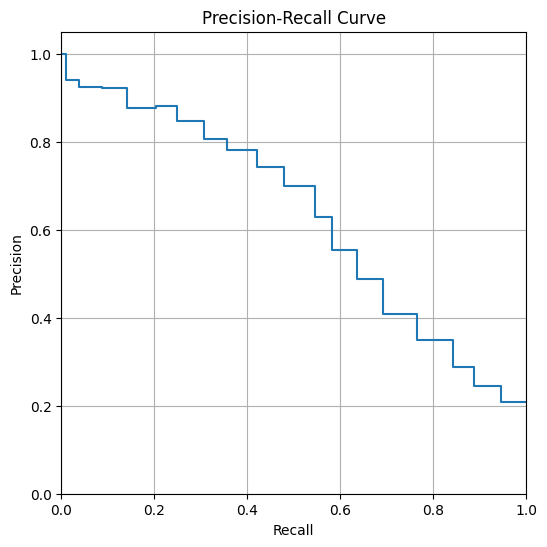

In [41]:
model = RandomForestClassifier(n_estimators=18,random_state=12345)
model.fit(scaled_features_train,target_train)

probabilities_test = model.predict_proba(scaled_features_test)
precision, recall, thresholds = precision_recall_curve(
    target_test, probabilities_test[:, 1]
)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

La gráfica la obtivimos con los hiperparametros del modelo establecidos en ejercicos aneteriores el cual es `n_estimatirs = 33`. 

### Paso 7. Árboles de Decisión.

#### Modelo.

In [42]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(scaled_features_train,target_train)

train_prediction = model.predict(scaled_features_train)
test_prediction = model.predict(scaled_features_test)
valid_prediction = model.predict(scaled_features_valid)

print('Exactitud con el método accuracy_score\n')
print(f"Entrenameinto: {accuracy_score(target_train,train_prediction)}")
print(f"Prueba: {accuracy_score(target_test,test_prediction)}")
print(f"Validación: {accuracy_score(target_valid,valid_prediction)}")

Exactitud con el método accuracy_score

Entrenameinto: 1.0
Prueba: 0.773
Validación: 0.7095


#### Paso 7.1. Matriz de confusión.

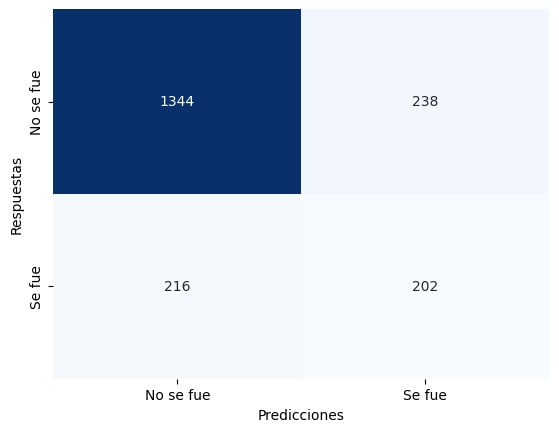

In [43]:
matrix = sns.heatmap(confusion_matrix(target_test,test_prediction),
                     annot=True,fmt='.5g',
                     cbar=False,cmap='Blues',
                     xticklabels=['No se fue','Se fue'],
                     yticklabels=['No se fue','Se fue'])
matrix.set_xlabel('Predicciones')
matrix.set_ylabel('Respuestas')
plt.show()

#### Paso 7.2 Métricas de recall, precision y f1.

In [44]:
print(f"Recall: {recall_score(target_test,test_prediction)}\n")

print(f"Precision: {precision_score(target_test,test_prediction)}\n")

print(f"Valor F1: {f1_score(target_test,test_prediction)}")

Recall: 0.48325358851674644

Precision: 0.4590909090909091

Valor F1: 0.47086247086247085


#### Paso 7.3. Valor F1 con sobremuestreo y submuestreo.

##### Paso 7.3.1. Sobremuestreo.

In [45]:
best_valor_f1 = 0
best_estimator = 0
for estimator in np.arange(1,50,1):
    model = DecisionTreeClassifier(max_depth=estimator,random_state=12345)
    upsampled_features,upsampled_target = upsample(scaled_features_train,target_train,10)
    model.fit(upsampled_features,upsampled_target)
    prediction = model.predict(scaled_features_valid)
    valor_f1 = f1_score(target_valid,prediction)
    print(f"Valor F1: {valor_f1}")
    if valor_f1 > best_valor_f1:
        best_valor_f1 = valor_f1
        best_estimator = estimator

print(f"\nMejor max_depth: {best_estimator}\nMejor valor F1: {best_valor_f1}") 

Valor F1: 0.3491539413949649
Valor F1: 0.4821958456973294
Valor F1: 0.43746616134271793
Valor F1: 0.4620213433772756
Valor F1: 0.441340782122905
Valor F1: 0.425754060324826
Valor F1: 0.4823773324118867
Valor F1: 0.4497117232543241
Valor F1: 0.449468085106383
Valor F1: 0.467870036101083
Valor F1: 0.4714946070878274
Valor F1: 0.4737678855325914
Valor F1: 0.4765957446808511
Valor F1: 0.48424842484248426
Valor F1: 0.49761677788369874
Valor F1: 0.48185483870967744
Valor F1: 0.483971044467425
Valor F1: 0.47629310344827586
Valor F1: 0.4728079911209767
Valor F1: 0.4682814302191465
Valor F1: 0.477751756440281
Valor F1: 0.4738095238095238
Valor F1: 0.4745762711864407
Valor F1: 0.45680473372781066
Valor F1: 0.465005931198102
Valor F1: 0.46246973365617433
Valor F1: 0.46099290780141844
Valor F1: 0.46099290780141844
Valor F1: 0.46099290780141844
Valor F1: 0.46099290780141844
Valor F1: 0.46099290780141844
Valor F1: 0.46099290780141844
Valor F1: 0.46099290780141844
Valor F1: 0.46099290780141844
Valor 

##### Paso 7.3.1. Submuestreo.

In [46]:
best_valor_f1 = 0
best_estimator = 0
for estimator in np.arange(1,50,1):
    model = DecisionTreeClassifier(max_depth=estimator,random_state=12345)
    
    downsampled_features,downsampled_target = downsample(scaled_features_train,target_train,0.1)
    
    model.fit(downsampled_features,downsampled_target)
    prediction = model.predict(scaled_features_valid)
    valor_f1 = f1_score(target_valid,prediction)
    print(f"Valor F1: {valor_f1}")
    if valor_f1 > best_valor_f1:
        best_valor_f1 = valor_f1
        best_estimator = estimator

print(f"\nMejor max_depth: {best_estimator}\nMejor valor F1: {best_valor_f1}") 

Valor F1: 0.4683734939759036
Valor F1: 0.4821958456973294
Valor F1: 0.43868179362506754
Valor F1: 0.44707207207207206
Valor F1: 0.46467218332272436
Valor F1: 0.4391657010428737
Valor F1: 0.428743961352657
Valor F1: 0.43456162642947904
Valor F1: 0.40950639853747717
Valor F1: 0.3960273122284296
Valor F1: 0.40152963671128106
Valor F1: 0.4010184595798854
Valor F1: 0.40304182509505704
Valor F1: 0.3896595208070618
Valor F1: 0.3989802421924793
Valor F1: 0.3979721166032953
Valor F1: 0.3979721166032953
Valor F1: 0.3979721166032953
Valor F1: 0.3979721166032953
Valor F1: 0.3979721166032953
Valor F1: 0.3979721166032953
Valor F1: 0.3979721166032953
Valor F1: 0.3979721166032953
Valor F1: 0.3979721166032953
Valor F1: 0.3979721166032953
Valor F1: 0.3979721166032953
Valor F1: 0.3979721166032953
Valor F1: 0.3979721166032953
Valor F1: 0.3979721166032953
Valor F1: 0.3979721166032953
Valor F1: 0.3979721166032953
Valor F1: 0.3979721166032953
Valor F1: 0.3979721166032953
Valor F1: 0.3979721166032953
Valor F1

El mejor valor de F1 es 0.4976 en el conjunto con sobremuestreo. Vamos a trabajor con esos datos para seguir mejorando el modelo.

#### Paso 7.4 Umbral de clasificación y ajuste.

##### Paso 7.4.1 Sobremuestreo.

Mejor valor F1 delos pasos anteriores.

In [47]:
best_valor_f1 = 0
best_estimator = 0

for estimator in np.arange(1,50,1):
    
    model = DecisionTreeClassifier(max_depth=estimator,random_state=12345)

    model.fit(scaled_features_train,target_train)
    
    probabilities_test = model.predict_proba(scaled_features_test)
    probabilities_one_test = probabilities_test[:,1]
    
    print(f"Itereación: {estimator}")
    
    for threshold in np.arange(0,1,0.05):
        
        predicted_test = probabilities_one_test > threshold
        
        recall = recall_score(target_test,predicted_test)
        precision = precision_score(target_test,predicted_test)
        f1 = f1_score(target_test,predicted_test)
        
        print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, F1 = {:.3F}'.format(threshold, precision, recall,f1)) 
        
        if f1 > best_valor_f1:
            best_f1 = f1
            best_estimator = estimator
            
print(f"\nEl mejor valor de f1 es {best_f1} en la iteración {best_estimator}.")

Itereación: 1
Threshold = 0.00 | Precision = 0.209, Recall = 1.000, F1 = 0.346
Threshold = 0.05 | Precision = 0.209, Recall = 1.000, F1 = 0.346
Threshold = 0.10 | Precision = 0.209, Recall = 1.000, F1 = 0.346
Threshold = 0.15 | Precision = 0.435, Recall = 0.586, F1 = 0.499
Threshold = 0.20 | Precision = 0.435, Recall = 0.586, F1 = 0.499
Threshold = 0.25 | Precision = 0.435, Recall = 0.586, F1 = 0.499
Threshold = 0.30 | Precision = 0.435, Recall = 0.586, F1 = 0.499
Threshold = 0.35 | Precision = 0.435, Recall = 0.586, F1 = 0.499
Threshold = 0.40 | Precision = 0.435, Recall = 0.586, F1 = 0.499
Threshold = 0.45 | Precision = 0.000, Recall = 0.000, F1 = 0.000
Threshold = 0.50 | Precision = 0.000, Recall = 0.000, F1 = 0.000
Threshold = 0.55 | Precision = 0.000, Recall = 0.000, F1 = 0.000
Threshold = 0.60 | Precision = 0.000, Recall = 0.000, F1 = 0.000
Threshold = 0.65 | Precision = 0.000, Recall = 0.000, F1 = 0.000
Threshold = 0.70 | Precision = 0.000, Recall = 0.000, F1 = 0.000
Threshold =

d:\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: Unde

Threshold = 0.45 | Precision = 0.604, Recall = 0.459, F1 = 0.522
Threshold = 0.50 | Precision = 0.604, Recall = 0.459, F1 = 0.522
Threshold = 0.55 | Precision = 0.604, Recall = 0.459, F1 = 0.522
Threshold = 0.60 | Precision = 0.604, Recall = 0.459, F1 = 0.522
Threshold = 0.65 | Precision = 0.744, Recall = 0.077, F1 = 0.139
Threshold = 0.70 | Precision = 0.744, Recall = 0.077, F1 = 0.139
Threshold = 0.75 | Precision = 0.744, Recall = 0.077, F1 = 0.139
Threshold = 0.80 | Precision = 0.000, Recall = 0.000, F1 = 0.000
Threshold = 0.85 | Precision = 0.000, Recall = 0.000, F1 = 0.000
Threshold = 0.90 | Precision = 0.000, Recall = 0.000, F1 = 0.000
Threshold = 0.95 | Precision = 0.000, Recall = 0.000, F1 = 0.000
Itereación: 3
Threshold = 0.00 | Precision = 0.209, Recall = 1.000, F1 = 0.346
Threshold = 0.05 | Precision = 0.297, Recall = 0.914, F1 = 0.448
Threshold = 0.10 | Precision = 0.297, Recall = 0.914, F1 = 0.448
Threshold = 0.15 | Precision = 0.297, Recall = 0.914, F1 = 0.448
Threshold =

In [48]:
best_valor_f1 = 0
best_estimator = 0

for estimator in np.arange(1,50,1):
    
    model = DecisionTreeClassifier(max_depth=estimator,random_state=12345)
    
    upsampled_features,upsampled_target = upsample(scaled_features_train,target_train,10)
    model.fit(upsampled_features,upsampled_target)
    
    probabilities_test = model.predict_proba(scaled_features_test)
    probabilities_one_test = probabilities_test[:,1]
    
    print(f"Itereación: {estimator}")
    
    for threshold in np.arange(0,1,0.05):
        
        predicted_test = probabilities_one_test > threshold
        
        recall = recall_score(target_test,predicted_test)
        precision = precision_score(target_test,predicted_test)
        f1 = f1_score(target_test,predicted_test)
        
        print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, F1 = {:.3F}'.format(threshold, precision, recall,f1)) 
        
        if f1 > best_valor_f1:
            best_f1 = f1
            best_estimator = estimator
            
print(f"\nEl mejor valor de f1 es {best_f1} en la iteración {best_estimator} con sobremuestreo.")

Itereación: 1
Threshold = 0.00 | Precision = 0.209, Recall = 1.000, F1 = 0.346
Threshold = 0.05 | Precision = 0.209, Recall = 1.000, F1 = 0.346
Threshold = 0.10 | Precision = 0.209, Recall = 1.000, F1 = 0.346
Threshold = 0.15 | Precision = 0.209, Recall = 1.000, F1 = 0.346
Threshold = 0.20 | Precision = 0.209, Recall = 1.000, F1 = 0.346
Threshold = 0.25 | Precision = 0.209, Recall = 1.000, F1 = 0.346
Threshold = 0.30 | Precision = 0.209, Recall = 1.000, F1 = 0.346
Threshold = 0.35 | Precision = 0.209, Recall = 1.000, F1 = 0.346
Threshold = 0.40 | Precision = 0.209, Recall = 1.000, F1 = 0.346
Threshold = 0.45 | Precision = 0.209, Recall = 1.000, F1 = 0.346
Threshold = 0.50 | Precision = 0.209, Recall = 1.000, F1 = 0.346
Threshold = 0.55 | Precision = 0.349, Recall = 0.749, F1 = 0.476
Threshold = 0.60 | Precision = 0.349, Recall = 0.749, F1 = 0.476
Threshold = 0.65 | Precision = 0.349, Recall = 0.749, F1 = 0.476
Threshold = 0.70 | Precision = 0.349, Recall = 0.749, F1 = 0.476
Threshold =

d:\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Threshold = 0.00 | Precision = 0.209, Recall = 0.998, F1 = 0.345
Threshold = 0.05 | Precision = 0.209, Recall = 0.998, F1 = 0.345
Threshold = 0.10 | Precision = 0.209, Recall = 0.998, F1 = 0.345
Threshold = 0.15 | Precision = 0.209, Recall = 0.998, F1 = 0.345
Threshold = 0.20 | Precision = 0.209, Recall = 0.998, F1 = 0.345
Threshold = 0.25 | Precision = 0.209, Recall = 0.998, F1 = 0.345
Threshold = 0.30 | Precision = 0.275, Recall = 0.943, F1 = 0.426
Threshold = 0.35 | Precision = 0.275, Recall = 0.943, F1 = 0.426
Threshold = 0.40 | Precision = 0.275, Recall = 0.943, F1 = 0.426
Threshold = 0.45 | Precision = 0.275, Recall = 0.943, F1 = 0.426
Threshold = 0.50 | Precision = 0.275, Recall = 0.943, F1 = 0.426
Threshold = 0.55 | Precision = 0.275, Recall = 0.943, F1 = 0.426
Threshold = 0.60 | Precision = 0.357, Recall = 0.787, F1 = 0.491
Threshold = 0.65 | Precision = 0.357, Recall = 0.787, F1 = 0.491
Threshold = 0.70 | Precision = 0.357, Recall = 0.787, F1 = 0.491
Threshold = 0.75 | Precis

Podemos observar que el valor f1 se mantiene constante cuanto va subiendo el umbral en cada iteración.

### Paso 7.5 Gráfica Precision-Recall Curve

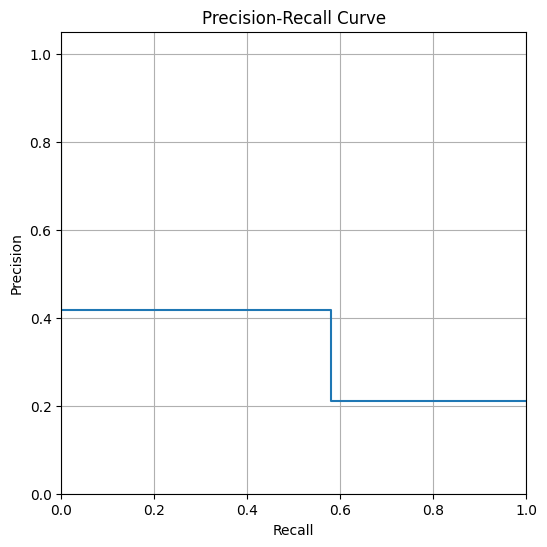

In [49]:
model = DecisionTreeClassifier(max_depth=1,random_state=12345)
model.fit(scaled_features_train,target_train)

probabilities_valid = model.predict_proba(scaled_features_valid)
precision, recall, thresholds = precision_recall_curve(
    target_valid, probabilities_valid[:, 1]
)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

## Parte 3. Prueba Final del modelo con mejor rendimiento.

El mejor modelo con la mayor valor de F1 fue Bosques Aleatorios con `0.62`, umbral de calisificación de `0.3` y con el hiperparametro del modelo `n_estimator = 33`.

In [50]:
best_model = RandomForestClassifier(n_estimators=18,random_state=12345)
best_model.fit(scaled_features_train,target_train)

def custom_predict(features,target,threshold,model):
    probabilities_one = model.predict_proba(features)
    probability_prediction = probabilities_one[:,1] > threshold
    return probability_prediction

### Paso 8. Prueba 

#### Paso 8.1 Prueba con conjunto de validación.

In [51]:
for threshold in np.arange(0,1,0.05):
    probability_prediction = custom_predict(scaled_features_valid,target_valid,threshold,model=best_model)
    f1 = f1_score(target_valid,probability_prediction)
    precision = precision_score(target_valid,probability_prediction)
    recall = recall_score(target_valid,probability_prediction)
    print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, F1 = {:.3F}\n'.format(threshold, precision, recall,f1))
print(f"accuracy_score: {accuracy_score(target_valid,model.predict(scaled_features_valid))}")
    

Threshold = 0.00 | Precision = 0.242, Recall = 0.969, F1 = 0.387

Threshold = 0.05 | Precision = 0.242, Recall = 0.969, F1 = 0.387

Threshold = 0.10 | Precision = 0.284, Recall = 0.915, F1 = 0.434

Threshold = 0.15 | Precision = 0.338, Recall = 0.835, F1 = 0.482

Threshold = 0.20 | Precision = 0.400, Recall = 0.773, F1 = 0.527

Threshold = 0.25 | Precision = 0.465, Recall = 0.704, F1 = 0.560

Threshold = 0.30 | Precision = 0.533, Recall = 0.638, F1 = 0.581

Threshold = 0.35 | Precision = 0.573, Recall = 0.556, F1 = 0.564

Threshold = 0.40 | Precision = 0.637, Recall = 0.478, F1 = 0.546

Threshold = 0.45 | Precision = 0.668, Recall = 0.404, F1 = 0.504

Threshold = 0.50 | Precision = 0.708, Recall = 0.366, F1 = 0.483

Threshold = 0.55 | Precision = 0.708, Recall = 0.366, F1 = 0.483

Threshold = 0.60 | Precision = 0.753, Recall = 0.324, F1 = 0.453

Threshold = 0.65 | Precision = 0.789, Recall = 0.274, F1 = 0.407

Threshold = 0.70 | Precision = 0.812, Recall = 0.215, F1 = 0.340

Threshold 

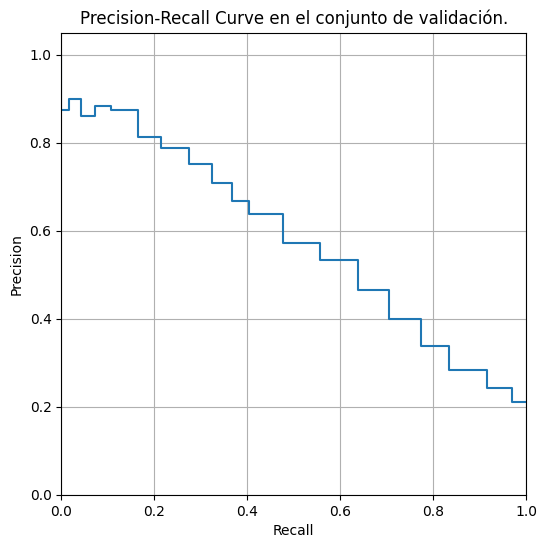

In [52]:
probabilities_valid = best_model.predict_proba(scaled_features_valid)
precision, recall, thresholds = precision_recall_curve(
    target_valid, probabilities_valid[:, 1]
)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve en el conjunto de validación.')
plt.grid(True)
plt.show()

Haciendo la prueba con el conjunto de validación, obtuvimos que el `umbral=0.3` dió el mejor valor de f1 que dió como resultado `0.581`

#### Paso 8.2 Prueba con conjunto de prueba.

In [53]:
for threshold in np.arange(0,1,0.05):
    probability_prediction = custom_predict(scaled_features_test,target_test,threshold,model=best_model)
    f1 = f1_score(target_test,probability_prediction)
    precision = precision_score(target_test,probability_prediction)
    recall = recall_score(target_test,probability_prediction)
    print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, F1 = {:.3F}'.format(threshold, precision, recall,f1)) 
print(f"\naccuracy_score: {accuracy_score(target_test,model.predict(scaled_features_test))}") 

Threshold = 0.00 | Precision = 0.245, Recall = 0.945, F1 = 0.389
Threshold = 0.05 | Precision = 0.245, Recall = 0.945, F1 = 0.389
Threshold = 0.10 | Precision = 0.288, Recall = 0.888, F1 = 0.435
Threshold = 0.15 | Precision = 0.349, Recall = 0.842, F1 = 0.494
Threshold = 0.20 | Precision = 0.409, Recall = 0.766, F1 = 0.533
Threshold = 0.25 | Precision = 0.487, Recall = 0.691, F1 = 0.572
Threshold = 0.30 | Precision = 0.554, Recall = 0.636, F1 = 0.592
Threshold = 0.35 | Precision = 0.628, Recall = 0.581, F1 = 0.604
Threshold = 0.40 | Precision = 0.699, Recall = 0.545, F1 = 0.613
Threshold = 0.45 | Precision = 0.743, Recall = 0.478, F1 = 0.582
Threshold = 0.50 | Precision = 0.782, Recall = 0.421, F1 = 0.547
Threshold = 0.55 | Precision = 0.782, Recall = 0.421, F1 = 0.547
Threshold = 0.60 | Precision = 0.805, Recall = 0.356, F1 = 0.494
Threshold = 0.65 | Precision = 0.848, Recall = 0.306, F1 = 0.450
Threshold = 0.70 | Precision = 0.881, Recall = 0.249, F1 = 0.388
Threshold = 0.75 | Precis

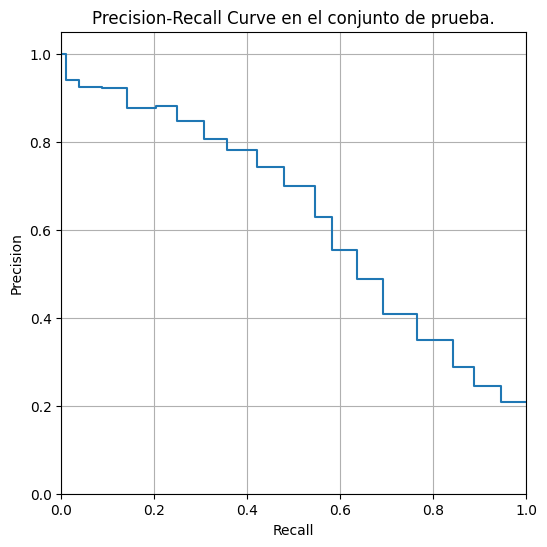

In [54]:
probabilities_test = best_model.predict_proba(scaled_features_test)
precision, recall, thresholds = precision_recall_curve(
    target_test, probabilities_test[:, 1]
)

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve en el conjunto de prueba.')
plt.grid(True)
plt.show()

En el conjunto de prueba, obtuvimos que el `umbral=0.4` dió el mejor valor de f1 que dió como resultado `0.613` mayor al valor objetivo que estabamos buscando obtener.

## Part 4. Conclusiones.

En este proyecto evaluamos diferentes modelos de aprendizaje supervisado, de los cuales fueron Regresión Lineal, Bosques Aleatorios y Árboles de decisión, para identificar a las personas que dejan de ser cliente en el banco. En la selección y evaluación de los modelos el que obtuvo el valor más alto de F1 fue Bosques Aleatorios. Tomando en cuenta el `umbral de clasificación` y los `hiperparametros` correspondientes. En la prueba final de modelo definitivo obtuvimos un umbral y valor f1 `0.4` y `0.613` en el conjunto de prueba y `0.3` y `0.581` en el conjunto de validación respectivamente. Nuestro objetivo fue identificar todos los posibles casos de positivos, obteniendo el valor `recall` y valor `f1` más alto para dicha tarea. La selección de umbral y f1, dependerá de lo que queremos que haga el modelo. Por ejemplo, si queremos que ponga más peso en la lo cliente se sí han ido o  que no se han ido. lLevando a acabo diferentes métricas.